Source: https://www.kaggle.com/code/alvinai9603/predict-next-point-with-the-imu-data/notebook

In [4]:
#Looks like the data format was pretty different in the 2021 competition

# Predict Next Point with the IMU Data
Author: **Alvin.ai**<br>
IMU is Inertial Measurement Unit, whicn involves accelerometer, gyroscope asn so on. In Microsoft Research's Indoor Location & Navigation Competition, many kagglers used the IMU Data. In recent days, I attempted to build a model to utilize the given sensors' data and I found that it works for me as below:<br>
1. Reject Outlier + KF Smooth + Phone Mean: LB-**5.653**
2. **IMU Prediction** + Reject Outlier + KF Smooth + Phone Mean: LB-**5.476**

What I do is to simple, **use historical points with sensors' dataset to predict where the next point is.**<br>
Talk is cheap, show you the code. Hope it is helpful to you.<br>
By the way, **I am looking forward to find a teammates, if you're interested, pls see the end of this kernal.**<br>


In [3]:
import math
import numpy as np
# from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [19]:
data_dir = Path('../data/2021-07-19-US-MTV-1/GooglePixel4')
bl_trn_fname = 'device_gnss.csv'
# bl_tst_fname = 'baseline_locations_test.csv'
# sample_fname = 'sample_submission.csv'

In [21]:
bl_trn_df = pd.read_csv(data_dir / bl_trn_fname)
# bl_tst_df = pd.read_csv(data_dir / bl_tst_fname)
# sample_df = pd.read_csv(data_dir / sample_fname)

In [ ]:
print('Baseline Train shape:', bl_trn_df.shape)
print('Baseline Test shape:', bl_tst_df.shape)
print('Test shape:', sample_df.shape)

## 1. Euler Angles to Rotation Vector
Euler Angles <-> Rotation Matrix <-> Rotation Vector<br>
More info.:[About IMU: OrientationDeg to Rotation Vector](https://www.kaggle.com/c/google-smartphone-decimeter-challenge/discussion/247834)

In [5]:
# pitch:y
# yaw:z
# roll:x
def an2v(y_delta, z_delta, x_delta):
    '''
    Euler Angles ->Rotation Matrix -> Rotation Vector

    Input：
        1. y_delta          (float): the angle with rotateing around y-axis.
        2. z_delta         (float): the angle with rotateing around z-axis. 
        3. x_delta         (float): the angle with rotateing around x-axis. 
    Output：
        rx/ry/rz             (float): the rotation vector with rotateing 
    
    Code Ref.: https://www.zacobria.com/universal-robots-knowledge-base-tech-support-forum-hints-tips/python-code-example-of-converting-rpyeuler-angles-to-rotation-vectorangle-axis-for-universal-robots/
    (Note：In Code Ref: pitch=y,yaw=z,roll=x. But Google is pitch=x,yaw=z,roll=y)
    '''
    # yaw: z
    Rz_Matrix = np.matrix([
    [math.cos(z_delta), -math.sin(z_delta), 0],
    [math.sin(z_delta), math.cos(z_delta), 0],
    [0, 0, 1]
    ])
    
    # pitch: y
    Ry_Matrix = np.matrix([
    [math.cos(y_delta), 0, math.sin(y_delta)],
    [0, 1, 0],
    [-math.sin(y_delta), 0, math.cos(y_delta)]
    ])
    
    # roll: x
    Rx_Matrix = np.matrix([
    [1, 0, 0],
    [0, math.cos(x_delta), -math.sin(x_delta)],
    [0, math.sin(x_delta), math.cos(x_delta)]
    ])

    R = Rz_Matrix * Ry_Matrix * Rx_Matrix

    theta = math.acos(((R[0, 0] + R[1, 1] + R[2, 2]) - 1) / 2)
    multi = 1 / (2 * math.sin(theta))

    rx = multi * (R[2, 1] - R[1, 2]) * theta
    ry = multi * (R[0, 2] - R[2, 0]) * theta
    rz = multi * (R[1, 0] - R[0, 1]) * theta

    return rx, ry, rz

In [6]:
def v2a(rotation_v):
    '''
    Rotation Vector -> Rotation Matrix -> Euler Angles

    Input：
        rx/ry/rz             (float): the rotation vector with rotateing around x/y/z-axis.
    Output：
        1. y_delta          (float): the angle with rotateing around y-axis.
        2. z_delta         (float): the angle with rotateing around z-axis. 
        3. x_delta         (float): the angle with rotateing around x-axis.  
    '''
    # Rotation Vector -> Rotation Matrix
    R = Rodrigues(rotation_v)[0]

    sq = sqrt(R[2,1] ** 2 +  R[2,2] ** 2)

    if  not (sq < 1e-6) :
        x_delta = atan2(R[2,1] , R[2,2])
        y_delta = atan2(-R[2,0], sq)
        z_delta = atan2(R[1,0], R[0,0])
    else :
        x_delta = atan2(-R[1,2], R[1,1])
        y_delta = atan2(-R[2,0], sq)
        z_delta = 0

    return y_delta, z_delta, x_delta

## 2. Prepare IMU Dataset
This part is to prepare the dataset for the model. I divided this part into the following steps:<br>
(1) **Load GNSS Log**<br>
(2) **Merge sub-dataset** (Status/UncalAccel/UncalGyro/UncalMag/OrientationDeg)<br>
(3) **UTC to GpsEpoch**<br>
(4) **OrientationDeg to Rotation Vecto**r<br>
(5) **Calibrate Sensors' data**<br>
(6) **LatDeg&lngDeg to x/y/z**<br>
(7) **Orgainze Data** (eg. t1 t2 t3 t4 t5 -> t6)<br>
(8) **Clean Data** (unrelated-aixs features and uncalibrated features)<br>
(9) **Add Statistic Features**

In [ ]:
#I will need to convert this code chunk to the way the files were given in this years competition

In [ ]:
# UncalAccel,utcTimeMillis,elapsedRealtimeNanos,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2
# 
# UncalGyro,utcTimeMillis,elapsedRealtimeNanos,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec
# 
# UncalMag,utcTimeMillis,elapsedRealtimeNanos,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT

In [ ]:
# Accelerometer: Measures change in velocity (m/s2)
# Gyroscopes: Measures change in rotation (rad/s)
# Magnetometer: Measures magnetic field (μT)

# https://www.kaggle.com/code/iamleonie/intro-to-indoor-location-navigation

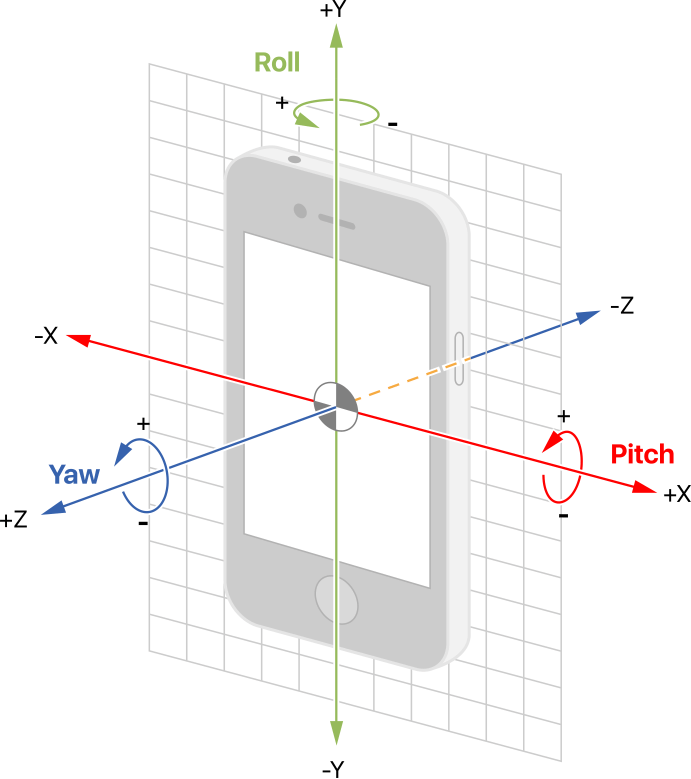

In [7]:
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'Raw', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [8]:
def UTC2GpsEpoch(df):
    '''UTC to GpsEpoch
    
    utcTimeMillis         : UTC epoch (1970/1/1)
    millisSinceGpsEpoch   : GPS epoch(1980/1/6 midnight 12:00 UTC)
    
    Ref: https://www.kaggle.com/c/google-smartphone-decimeter-challenge/discussion/239187
    '''
    dt_offset = pd.to_datetime('1980-01-06 00:00:00') 
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    df['millisSinceGpsEpoch'] = df['utcTimeMillis'] - dt_offset_in_ms + 18000
    return df

In [22]:
# def prepare_imu_data(data_dir, dataset_name, cname, pname, bl_df):
def prepare_imu_data(data_dir, dataset_name, cname, pname, bl_df):
    '''Prepare IMU Dataset (For Train: IMU+GT+BL; For Test: IMU+BL)
    Input：
        1. data_dir: data_dir
        2. dataset_name: dataset name（'train'/'test'）
        3. cname: CollectionName
        4. pname: phoneName
        5. bl_df: baseline's dataframe
    Output：df_all
    '''
    # load GNSS log
#     gnss_df = gnss_log_to_dataframes(str(data_dir / dataset_name / cname / pname / f'{pname}_GnssLog.txt'))

#changed this to just get it to work
    gnss_df = gnss_log_to_dataframes(str(data_dir / 'device_imu.csv'))
    print('sub-dataset shape：')
    print('Raw:', gnss_df['Raw'].shape)
    print('Status:', gnss_df['Status'].shape)
    print('UncalAccel:', gnss_df['UncalAccel'].shape)
    print('UncalGyro:', gnss_df['UncalGyro'].shape)
    print('UncalMag:', gnss_df['UncalMag'].shape)
    print('OrientationDeg:', gnss_df['OrientationDeg'].shape)
    print('Fix:', gnss_df['Fix'].shape)

    # merge sub-datasets
    # accel + gyro
    imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                           gnss_df['UncalGyro'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # (accel + gyro) + mag
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['UncalMag'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # ((accel + gyro) + mag) + OrientationDeg
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['OrientationDeg'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
   
    # UTC->GpsEpoch
    imu_df = UTC2GpsEpoch(imu_df)

    # print IMU time
    dt_offset = pd.to_datetime('1980-01-06 00:00:00')
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    tmp_datetime = pd.to_datetime(imu_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
    print(f"imu_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")


    if dataset_name == 'train':
        # read GT dataset
        gt_path = data_dir / dataset_name / cname / pname / 'ground_truth.csv'
        gt_df = pd.read_csv(gt_path, usecols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg'])

        # print GT time
        tmp_datetime = pd.to_datetime(gt_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
        print(f"gt_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")

        # merge GT dataset
        imu_df = pd.merge_asof(gt_df.sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')
    elif dataset_name == 'test':
        # merge smaple_df
        imu_df = pd.merge_asof(sample_df.sort_values('millisSinceGpsEpoch'),
                           imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                           on = 'millisSinceGpsEpoch',
                           direction='nearest')

    # OrientationDeg -> Rotation Vector
    rxs = []
    rys = []
    rzs = []
    
    #where did yawdeg and rolldeg and pitchdeg get added into the data set????
    for i in range(len(imu_df)):
        y_delta = imu_df['rollDeg'].iloc[i]
        z_delta = imu_df['yawDeg'].iloc[i]
        x_delta = imu_df['pitchDeg'].iloc[i]
        rx, ry, rz = an2v(y_delta, z_delta, x_delta)
        rxs.append(rx)
        rys.append(ry)
        rzs.append(rz)

    imu_df['ahrsX'] = rxs
    imu_df['ahrsY'] = rys
    imu_df['ahrsZ'] = rzs

    # calibrate sensors' reading
    for axis in ['X', 'Y', 'Z']:
        imu_df['Accel{}Mps2'.format(axis)] = imu_df['UncalAccel{}Mps2'.format(axis)] - imu_df['Bias{}Mps2'.format(axis)]
        imu_df['Gyro{}RadPerSec'.format(axis)] = imu_df['UncalGyro{}RadPerSec'.format(axis)] - imu_df['Drift{}RadPerSec'.format(axis)]
        imu_df['Mag{}MicroT'.format(axis)] = imu_df['UncalMag{}MicroT'.format(axis)] - imu_df['Bias{}MicroT'.format(axis)]

        # clearn bias features
        imu_df.drop(['Bias{}Mps2'.format(axis), 'Drift{}RadPerSec'.format(axis), 'Bias{}MicroT'.format(axis)], axis = 1, inplace = True) 

    if dataset_name == 'train':
        # merge Baseline dataset：imu_df + bl_df = (GT + IMU) + Baseline
        df_all = pd.merge(imu_df.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'}),
                      bl_df.drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
                      on = ['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
    elif dataset_name == 'test':
        df_all = pd.merge(imu_df,
              bl_df[(bl_df['collectionName']==cname) & (bl_df['phoneName']==pname)].drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
              on = ['millisSinceGpsEpoch'])
        df_all.drop(['phone'], axis=1, inplace=True)
        
    return df_all

In [10]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)
def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt

In [11]:
def get_xyz(df_all, dataset_name):
    # baseline: lat/lngDeg -> x/y/z
    df_all['Xbl'], df_all['Ybl'], df_all['Zbl'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.latDeg_bl, x.lngDeg_bl, x.heightAboveWgs84EllipsoidM), axis=1))
    
    if dataset_name == 'train':
        # gt: lat/lngDeg -> x/y/z
        df_all['Xgt'], df_all['Ygt'], df_all['Zgt'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.latDeg_gt, x.lngDeg_gt, x.heightAboveWgs84EllipsoidM), axis=1))
        # copy lat/lngDeg
        lat_lng_df = df_all[['latDeg_gt','lngDeg_gt', 'latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['latDeg_gt','lngDeg_gt', 'latDeg_bl', 'lngDeg_bl'], axis = 1, inplace = True)
    elif dataset_name == 'test':
        # copy lat/lngDeg
        lat_lng_df = df_all[['latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['latDeg_bl', 'lngDeg_bl', 'latDeg','lngDeg',], axis = 1, inplace = True)     
        
    return lat_lng_df, df_all

In [12]:
def prepare_df_train(df_all_train, window_size):
    '''prepare training dataset with all aixses'''
    tgt_df = df_all_train.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']]

    # Historical Feature names
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # Window Sliding
    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7

    # Add historical data 
    df_train = pd.DataFrame()
    features = []
    xs = []
    ys = []
    zs = []

    for start_idx in range(moving_times):
        feature_list = list()
        x_list = list()
        y_list = list()
        z_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        x_list.append(tgt_df['Xgt'].iloc[start_idx + window_size])
        y_list.append(tgt_df['Ygt'].iloc[start_idx + window_size])
        z_list.append(tgt_df['Zgt'].iloc[start_idx + window_size])

        features.append(feature_list)
        xs.extend(x_list)
        ys.extend(y_list)
        zs.extend(z_list)

    df_train = pd.DataFrame(features, columns = hist_feats)
    df_train['Xgt'] = xs
    df_train['Ygt'] = ys
    df_train['Zgt'] = zs
    
    # clean single-value feature: collectionName_[1-5]\phoneName_[1-5]
    tmp_feats = []
    for fn in list(df_train):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_train = df_train[tmp_feats]

    # clean time feature
    tmp_drop_feats = []
    for f in list(df_train):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True):
            tmp_drop_feats.append(f)
    df_train.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_train

In [13]:
def prepare_df_test(df_all_test, window_size):
    '''prepare testing dataset with all aixses'''
    tgt_df = df_all_test.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']] 
    
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7
    df_test = pd.DataFrame()
    features = []

    for start_idx in range(moving_times):
        feature_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        features.append(feature_list)

    df_test = pd.DataFrame(features, columns = hist_feats)

    tmp_feats = []
    for fn in list(df_test):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_test = df_test[tmp_feats]

    tmp_drop_feats = []
    for f in list(df_test):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True) or (f.startswith('elapsedRealtimeNanos') == True):
            tmp_drop_feats.append(f)
    df_test.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_test

In [14]:
def remove_other_axis_feats(df_all, tgt_axis):
    '''unrelated-aixs features and uncalibrated features'''
    # Clean unrelated-aixs features
    all_imu_feats = ['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2',
                     'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
                     'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
                     'ahrsX', 'ahrsY', 'ahrsZ',
                     'AccelXMps2', 'AccelYMps2', 'AccelZMps2',
                     'GyroXRadPerSec', 'GyroZRadPerSec', 'GyroYRadPerSec',
                     'MagXMicroT', 'MagYMicroT', 'MagZMicroT',
                     'yawZDeg', 'rollYDeg', 'pitchXDeg',
                     'Xbl', 'Ybl', 'Zbl']
    tgt_imu_feats = []
    for axis in ['X', 'Y', 'Z']:
        if axis != tgt_axis:
            for f in all_imu_feats:
                if f.find(axis) >= 0:
                    tgt_imu_feats.append(f)
            
    tmp_drop_feats = []
    for f in list(df_all):
        if f.split('_')[0] in tgt_imu_feats:
            tmp_drop_feats.append(f)

    tgt_df = df_all.drop(tmp_drop_feats, axis = 1)
    
    # Clean uncalibrated features
    uncal_feats = [f for f in list(tgt_df) if f.startswith('Uncal') == True]
    tgt_df = tgt_df.drop(uncal_feats, axis = 1)
    
    return tgt_df

In [15]:
def add_stat_feats(data, tgt_axis):
    for f in ['yawZDeg', 'rollYDeg', 'pitchXDeg']:
        if f.find(tgt_axis) >= 0:
            ori_feat = f
            break
            
    cont_feats = ['heightAboveWgs84EllipsoidM', 'ahrs{}'.format(tgt_axis),
           'Accel{}Mps2'.format(tgt_axis), 'Gyro{}RadPerSec'.format(tgt_axis), 'Mag{}MicroT'.format(tgt_axis),
            '{}bl'.format(tgt_axis)] + [ori_feat]
    
    for f in cont_feats:
        data[f + '_' + str(window_size) + '_mean'] = data[[f + f'_{i}' for i in range(1,window_size)]].mean(axis=1)
        data[f + '_' + str(window_size) + '_std'] = data[[f + f'_{i}' for i in range(1,window_size)]].std(axis=1)
        data[f + '_' + str(window_size) + '_max'] = data[[f + f'_{i}' for i in range(1,window_size)]].max(axis=1)
        data[f + '_' + str(window_size) + '_min'] = data[[f + f'_{i}' for i in range(1,window_size)]].min(axis=1)
        data[f + '_' + str(window_size) + '_median'] = data[[f + f'_{i}' for i in range(1,window_size)]].median(axis=1)
    return data

## 3. Modeling
Note: I only use the given axis features for predict the target axis location.<br>
For example, use features contains x-axis to predict the next x location.<br>
More, I used LGBM here.

In [16]:
# LightGBM
params = {
    'metric':'mse',
    'objective':'regression',
    'seed':2021,
    'boosting_type':'gbdt',
    'early_stopping_rounds':10,
    'subsample':0.7,
    'feature_fraction':0.7,
    'bagging_fraction': 0.7,
    'reg_lambda': 10
}
window_size = 30
verbose_flag = True
folds = 5

In [ ]:
# Example: I use SJC's dataset for training 
tgt_cns = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2']
cn2pn_df = bl_trn_df[['collectionName', 'phoneName']].drop_duplicates()

df_trains = []
lat_lng_df_trains = []
for tgt_cn in tqdm(tgt_cns):
    pns = list(cn2pn_df[cn2pn_df['collectionName'] == tgt_cn]['phoneName'].values)
    for tgt_pn in pns:
        print('Prepare Training Dataset：', tgt_cn + '_' + tgt_pn)  
        df_all_train = prepare_imu_data(data_dir, 'train', tgt_cn, tgt_pn, bl_trn_df)
        lat_lng_df_train, df_all_train = get_xyz(df_all_train, 'train')
        df_train = prepare_df_train(df_all_train,  window_size) # 所有轴的数据
        df_trains.append(df_train)
        lat_lng_df_trains.append(lat_lng_df_train)
        print('_'*20)
        
df_train = pd.concat(df_trains, axis = 0)
lat_lng_df_train = pd.concat(lat_lng_df_trains, axis = 0)
print('Final Dataset shape：', df_train.shape)

In [ ]:
# Example: I choose one of SJC collection from the test dataset as my test dataset, you can choose what as you like
cname_test = '2021-04-29-US-SJC-3'
pname_test = 'SamsungS20Ultra'
df_all_test = prepare_imu_data(data_dir, 'test', cname_test, pname_test, bl_tst_df)
lat_lng_df_test, df_all_test = get_xyz(df_all_test, 'test')
df_test = prepare_df_test(df_all_test,  window_size)
print('df_test:', df_test.shape)
print('df_test.columns:', df_test.columns)

In [ ]:
def training(df_train, df_test, tgt_axis, window_size):
    '''For the given axis target to train the model. Also, it has validation and prediciton.'''
    df_train = remove_other_axis_feats(df_train, tgt_axis)
    df_train = add_stat_feats(df_train, tgt_axis)
    df_test = remove_other_axis_feats(df_test, tgt_axis)
    df_test = add_stat_feats(df_test, tgt_axis)
    
    feature_names = [f for f in list(df_train) if f not in ['Xgt', 'Ygt', 'Zgt']]
    target = '{}gt'.format(tgt_axis)

    kfold = KFold(n_splits=folds, shuffle=True, random_state=params['seed'])

    pred_valid = np.zeros((len(df_train),)) 
    pred_test = np.zeros((len(df_test),)) 
    scores = []
    for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train, df_train[target])):
        X_train = df_train.iloc[trn_idx][feature_names]
        Y_train = df_train.iloc[trn_idx][target]
        X_val = df_train.iloc[val_idx][feature_names]
        Y_val = df_train.iloc[val_idx][target]

        model = lgb.LGBMRegressor(**params)
        lgb_model = model.fit(X_train, 
                              Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              verbose=0,
                              eval_metric=params['metric'],
                              early_stopping_rounds=params['early_stopping_rounds'])

        pred_valid[val_idx] = lgb_model.predict(X_val, num_iteration =  lgb_model.best_iteration_)
        pred_test += lgb_model.predict(df_test[feature_names], num_iteration =  lgb_model.best_iteration_)

        scores.append(lgb_model.best_score_['valid']['l2'])
    
    pred_test = pred_test /  kfold.n_splits
    
    if verbose_flag == True:
        print("Each Fold's MSE：{}, Average MSE：{:.4f}".format([np.round(v,2) for v in scores], np.mean(scores)))
        print("-"*60)
    return df_train, df_test, pred_valid, pred_test

In [ ]:
df_train_x, df_test_x, pred_valid_x, pred_test_x = training(df_train, df_test, 'X', window_size)
df_train_y, df_test_y, pred_valid_y, pred_test_y = training(df_train, df_test, 'Y', window_size)
df_train_z, df_test_z, pred_valid_z, pred_test_z = training(df_train, df_test, 'Z', window_size)

In [ ]:
val_compare_df = pd.DataFrame({'Xgt':df_train_x['Xgt'].values, 'Xpred':pred_valid_x,
                               'Ygt':df_train_y['Ygt'].values, 'Ypred':pred_valid_y,
                                'Zgt':df_train_z['Zgt'].values, 'Zpred':pred_valid_z})

In [ ]:
val_compare_df[['Zgt', 'Zpred']].plot(figsize=(16,8))

In [ ]:
val_compare_df[['Ygt', 'Ypred']].plot(figsize=(16,8))

We can see that, gt and pre is close to each other.

In [ ]:
# xyz -> lng, lat
lng_gt, lat_gt, _ = ECEF_to_WGS84(val_compare_df['Xgt'].values,val_compare_df['Ygt'].values,val_compare_df['Zgt'].values)
lng_pred, lat_pred, _ = ECEF_to_WGS84(val_compare_df['Xpred'].values,val_compare_df['Ypred'].values,val_compare_df['Zpred'].values)
lng_test_pred, lat_test_pred, _ = ECEF_to_WGS84(pred_test_x, pred_test_y, pred_test_z)

    
val_compare_df['latDeg_gt'] = lat_gt
val_compare_df['lngDeg_gt'] = lng_gt
val_compare_df['latDeg_pred'] = lat_pred
val_compare_df['lngDeg_pred'] = lng_pred
test_pred_df = pd.DataFrame({'latDeg':lat_test_pred, 'lngDeg':lng_test_pred})

In [ ]:
# From：https://www.kaggle.com/emaerthin/demonstration-of-the-kalman-filter
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

In [ ]:
# Baseline vs. GT
lat_lng_df_train['dist'] = calc_haversine(lat_lng_df_train.latDeg_gt, lat_lng_df_train.lngDeg_gt, 
                                lat_lng_df_train.latDeg_bl, lat_lng_df_train.lngDeg_bl)
print('dist_50:',np.percentile(lat_lng_df_train['dist'],50) )
print('dist_95:',np.percentile(lat_lng_df_train['dist'],95) )
print('avg_dist_50_95:',(np.percentile(lat_lng_df_train['dist'],50) + np.percentile(lat_lng_df_train['dist'],95))/2)
print('avg_dist:', lat_lng_df_train['dist'].mean())

In [ ]:
# IMU Prediction vs. GT
val_compare_df['dist'] = calc_haversine(val_compare_df.latDeg_gt, val_compare_df.lngDeg_gt, 
                                val_compare_df.latDeg_pred, val_compare_df.lngDeg_pred)
# IMU预测vsGT（多collection）
print('dist_50:',np.percentile(val_compare_df['dist'],50) )
print('dist_95:',np.percentile(val_compare_df['dist'],95) )
print('avg_dist_50_95:',(np.percentile(val_compare_df['dist'],50) + np.percentile(val_compare_df['dist'],95))/2)
print('avg_dist:', val_compare_df['dist'].mean())

In [ ]:
def visualize_trafic(df, center, zoom=15):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df):
    target_df = df
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [ ]:
# Visualization: Train dataset
cname = '2021-04-29-US-SJC-2'
pname = 'SamsungS20Ultra'
# IMU Prediciton
tmp0 = val_compare_df.copy()
tmp0.rename(columns={'latDeg_pred':'latDeg', 'lngDeg_pred':'lngDeg'}, inplace=True)
tmp0['phoneName'] = [cname + '_' + pname + '_imu_pred' for i in range(len(tmp0))]
# GT
tmp1 = val_compare_df.copy()
tmp1.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'}, inplace=True)
tmp1['phoneName'] = [cname + '_' + pname + '_gt' for i in range(len(tmp1))]
# Baseline
tmp2 = lat_lng_df_train.copy()
tmp2.rename(columns={'latDeg_bl':'latDeg', 'lngDeg_bl':'lngDeg'}, inplace=True)
tmp2['phoneName'] = [cname + '_' + pname + '_bl_pred' for i in range(len(tmp2))]

tmp = pd.concat([tmp0, tmp1, tmp2])
visualize_collection(tmp)

In [ ]:
# Visualization:: Test dataset
cname = '2021-04-29-US-SJC-3'
pname = 'SamsungS20Ultra'
tmp3 = test_pred_df.copy()
tmp3['phoneName'] = cname_test + '_' + pname_test + '_imu_pred' 

tmp4 = bl_tst_df.iloc[bl_tst_df[bl_tst_df['phone']==cname_test + '_' + pname_test].index[window_size:],3:5].copy()
tmp4['phoneName'] = cname_test + '_' + pname_test + '_bl_pred' 

tmp5 = pd.concat([tmp3, tmp4])
visualize_collection(tmp5)

## 4. Submission

In [ ]:
bl_tst_df.iloc[bl_tst_df[bl_tst_df['phone']==cname_test + '_' + pname_test].index[window_size:],3] = test_pred_df['latDeg'].values
bl_tst_df.iloc[bl_tst_df[bl_tst_df['phone']==cname_test + '_' + pname_test].index[window_size:],4] = test_pred_df['lngDeg'].values

# bl_tst_df.to_csv('../submit/imu_baseline_locations_test.csv', index = False)

The above code is just a template. I cannot promise it could improve a lot for you because i didn't publish my entire code (which contains some tricks). However, i hope my code could inspire you how to use GNSS log data. <br>

On the other hand, i am seeking for a nice teammate, here is my basic infomation:
1. I am fresh of Kaggle, but attend some competitions in China before.
2. I am Data Analyst from OPPO for more than one year (well, indoor game uses our phone's data).
3. I am graduated from University of Manchester, UK. I guess my English can handle the normal communication.
4. I have another teammate from china, too. (he is nice)
5. I can use 1-3 hrs/day for playing this competition but the weekend i got one day for fee.

What I hope:
1. You are Top 50 or related experience about phone locating.
2. You have time and energy to keep working on the game.
3. You are like to publish the code when we finished this game.
4. Most importance!!! you have great ideas!

If you want to join us, feel free to contact me. My email: **alvinai9603@outlook.com**<br>

Thanks.

In [73]:
gnss_df = gnss_log_to_dataframes(str(data_dir / 'device_imu.csv'))
gnss_df['UncalAccel'].head()

Loading ../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv


,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,1626727759439,0.041874,9.640682,-1.681556,0.0,0.0,0.0
1,1626727759449,0.133998,9.705887,-1.660021,0.0,0.0,0.0
2,1626727759459,-0.019143,9.719048,-1.815554,0.0,0.0,0.0
3,1626727759469,0.023330,9.615558,-1.554138,0.0,0.0,0.0
4,1626727759478,0.113659,9.670592,-1.682753,0.0,0.0,0.0


In [76]:
gt_path = data_dir / 'ground_truth.csv'
gt_df = pd.read_csv(gt_path, usecols = ['UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees'])
gt_df.head()

,LatitudeDegrees,LongitudeDegrees,UnixTimeMillis
0,37.444105,-122.232767,1626727759438
1,37.444105,-122.232767,1626727760438
2,37.444106,-122.232767,1626727761438
3,37.444106,-122.232767,1626727762438
4,37.444106,-122.232767,1626727763438


In [ ]:
#I think that unix and utc are pretty much the same??

In [119]:
gnss_df = gnss_log_to_dataframes(str(data_dir / 'device_imu.csv'))
print('sub-dataset shape：')
print('UncalAccel:', gnss_df['UncalAccel'].shape)
print('UncalGyro:', gnss_df['UncalGyro'].shape)
print('UncalMag:', gnss_df['UncalMag'].shape)

# merge sub-datasets
# accel + gyro
imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                       gnss_df['UncalGyro'].sort_values('utcTimeMillis'),
                       on = 'utcTimeMillis',
                       direction='nearest')
# (accel + gyro) + mag
imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                       gnss_df['UncalMag'].sort_values('utcTimeMillis'),
                       on = 'utcTimeMillis',
                       direction='nearest')

Loading ../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv
sub-dataset shape：
UncalAccel: (108019, 7)
UncalGyro: (96981, 7)
UncalMag: (43515, 7)


In [74]:
#me just trying to do imu data frame only
# def prepare_imu_data(data_dir, dataset_name, cname, pname, bl_df):
def prepare_imu_data(data_dir):
    '''Prepare IMU Dataset (For Train: IMU+GT+BL; For Test: IMU+BL)
    Input：
        1. data_dir: data_dir
        2. dataset_name: dataset name（'train'/'test'）
        3. cname: CollectionName
        4. pname: phoneName
        5. bl_df: baseline's dataframe
    Output：df_all
    '''
    # load GNSS log
#     gnss_df = gnss_log_to_dataframes(str(data_dir / dataset_name / cname / pname / f'{pname}_GnssLog.txt'))

#changed this to just get it to work
    gnss_df = gnss_log_to_dataframes(str(data_dir / 'device_imu.csv'))
    print('sub-dataset shape：')
    print('UncalAccel:', gnss_df['UncalAccel'].shape)
    print('UncalGyro:', gnss_df['UncalGyro'].shape)
    print('UncalMag:', gnss_df['UncalMag'].shape)

    # merge sub-datasets
    # accel + gyro
    imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                           gnss_df['UncalGyro'].sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # (accel + gyro) + mag
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['UncalMag'].sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # ((accel + gyro) + mag) + OrientationDeg
#     imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
#                            gnss_df['OrientationDeg'].sort_values('utcTimeMillis'),
#                            on = 'utcTimeMillis',
#                            direction='nearest')
   
    # UTC->GpsEpoch
#     imu_df = UTC2GpsEpoch(imu_df)

    # print IMU time
#     dt_offset = pd.to_datetime('1980-01-06 00:00:00')
#     dt_offset_in_ms = int(dt_offset.value / 1e6)
#     #below line changed from time since GPS epoch to utctimeMillis
#     tmp_datetime = pd.to_datetime(imu_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
#     print(f"imu_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")

    
#Originally had millisSinceGpsEpoch instead of UnixTimeMillis. I'm sure that will be a problem. need to read about tctime vs unx
#     if dataset_name == 'train':
        # read GT dataset
    gt_path = data_dir / 'ground_truth.csv'
    gt_df = pd.read_csv(gt_path, usecols = ['UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees'])

    # print GT time
    tmp_datetime = pd.to_datetime(gt_df['UnixTimeMillis'] + dt_offset_in_ms, unit='ms')
    print(f"gt_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")

    # merge GT dataset
    #ok not sure what i should get rid of here
    imu_df = pd.merge_asof(gt_df.sort_values('UnixTimeMillis'),
                           imu_df.sort_values('UnixTimeMillis'),
                           on = 'UnixTimeMillis',
                           direction='nearest')
#     elif dataset_name == 'test':
#         # merge smaple_df
#         imu_df = pd.merge_asof(sample_df.sort_values('millisSinceGpsEpoch'),
#                            imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
#                            on = 'millisSinceGpsEpoch',
#                            direction='nearest')

    # OrientationDeg -> Rotation Vector
    
#where on earth is orientationdeg coming from???
#I added this part
    pitch = [180 * math.atan(x/sqrt(y**2 + z**2))/math.pi for x, y, z in\
             zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])];
    roll = [180 * math.atan(y/sqrt(x**2 + z**2))/math.pi for x, y, z in\
            zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]

    yaw = [180 * math.atan(z/sqrt(x**2 + z**2))/math.pi for x, y , z in\
           zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]

    imu_df['pitchDeg'] = pitch
    imu_df['rollDeg'] = roll
    imu_df['yawDeg'] = yaw
    rxs = []
    rys = []
    rzs = []
    for i in range(len(imu_df)):
        y_delta = imu_df['rollDeg'].iloc[i]
        z_delta = imu_df['yawDeg'].iloc[i]
        x_delta = imu_df['pitchDeg'].iloc[i]
        rx, ry, rz = an2v(y_delta, z_delta, x_delta)
        rxs.append(rx)
        rys.append(ry)
        rzs.append(rz)

    imu_df['ahrsX'] = rxs
    imu_df['ahrsY'] = rys
    imu_df['ahrsZ'] = rzs

    # calibrate sensors' reading
    for axis in ['X', 'Y', 'Z']:
        imu_df['Accel{}Mps2'.format(axis)] =\
        imu_df['UncalAccel{}Mps2'.format(axis)] - imu_df['BiasUncalAccel{}Mps2'.format(axis)]
        
        imu_df['Gyro{}RadPerSec'.format(axis)] =\
        imu_df['UncalGyro{}RadPerSec'.format(axis)] - imu_df['BiasUncalGyro{}RadPerSec'.format(axis)]
        
        imu_df['Mag{}MicroT'.format(axis)] =\
        imu_df['UncalMag{}MicroT'.format(axis)] - imu_df['BiasUncal{}MicroT'.format(axis)]

        # clearn bias features
        imu_df.drop(['Bias{}Mps2'.format(axis), 'Drift{}RadPerSec'.format(axis), 'Bias{}MicroT'.format(axis)], axis = 1, inplace = True)

In [ ]:
# I guess I should calculate roll yaw and pitch?

In [143]:
imu_data = pd.read_csv('../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv')
imu_data

,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,UncalAccel,1626727759439,0.041874,9.640682,-1.681556,0.000000,0.000000,0.000000
1,UncalGyro,1626727759444,-0.001833,0.000916,0.000611,0.000000,0.000000,0.000000
2,UncalAccel,1626727759449,0.133998,9.705887,-1.660021,0.000000,0.000000,0.000000
3,UncalMag,1626727759458,70.500000,-35.193750,-3.318750,45.863167,21.554216,21.209393
4,UncalAccel,1626727759459,-0.019143,9.719048,-1.815554,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
248510,UncalMag,1626729655416,70.706245,-36.637500,-3.262500,45.863167,21.554216,21.209393
248511,UncalAccel,1626729655423,0.086740,9.720243,-1.707279,0.000000,0.000000,0.000000
248512,UncalMag,1626729655426,71.268745,-35.756250,-3.150000,45.863167,21.554216,21.209393
248513,UncalGyro,1626729655428,0.003512,0.000611,0.001222,0.000000,0.000000,0.000000


In [109]:
#these are the col names from the 2021 challenge
col_names = \
{'UncalAccel' : ["utcTimeMillis","UncalAccelXMps2","UncalAccelYMps2","UncalAccelZMps2",\
                             "BiasUncalAccelXMps2","BiasUncalAccelYMps2","BiasUncalAccelZMps2"],
'UncalGyro' : ['utcTimeMillis','UncalGyroXRadPerSec','UncalGyroYRadPerSec','UncalGyroZRadPerSec',\
               'BiasUncalGyroXRadPerSec','BiasUncalGyroYRadPerSec','BiasUncalGyroZRadPerSec'],
             
'UncalMag' : ['utcTimeMillis','UncalMagXMicroT','UncalMagYMicroT','UncalMagZMicroT',\
             'BiasUncalMagXMicroT','BiasUncalMagYMicroT','BiasUncalMagZMicroT']}

In [112]:
# def gnss_log_to_dataframes(path):
#     '''Load GNSS Log'''
#     print('Loading ' + path, flush = True)

path = '../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv'
gnss_section_names = {'UncalAccel', 'UncalGyro', 'UncalMag'}
with open(path) as f_open:
        datalines = f_open.readlines()
#     colnames = datalines[0].strip().split(',')[1:]
datas = {k: [] for k in gnss_section_names}
gnss_map = col_names
for dataline in datalines[1:]:
    dataline = dataline.split(',')
    datas[dataline[0]].append(dataline[1:])


results = dict()

for k, v in datas.items():
    results[k] = pd.DataFrame(v, columns=gnss_map[k])

for k, df in results.items():
    for col in df.columns:
        if col == 'CodeType':
            continue
        results[k][col] = pd.to_numeric(results[k][col])
# return results

In [118]:
#My update for 2022 challenge
def gnss_log_to_dataframes(path):
    '''Load IMU data'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'UncalAccel', 'UncalGyro', 'UncalMag'}
    with open(path) as f_open:
            datalines = f_open.readlines()
#     colnames = datalines[0].strip().split(',')[1:]
    datas = {k: [] for k in gnss_section_names}
    gnss_map = col_names
    for dataline in datalines[1:]:
        dataline = dataline.split(',')
        datas[dataline[0]].append(dataline[1:])


    results = dict()

    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])

    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])
    return results

In [115]:
test = gnss_log_to_dataframes('../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv')

Loading ../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv


In [30]:
#original function
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'MessageType', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
#         is_header = dataline.startswith('#')
#         dataline = dataline.strip('#').strip().split(',')
#         # skip over notes, version numbers, etc
#         if is_header and dataline[0] in gnss_section_names:
#             gnss_map[dataline[0]] = dataline[1:]
#         elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [116]:
prepare_imu_data(data_dir)

Loading ../data/2021-07-19-US-MTV-1/GooglePixel4/device_imu.csv
sub-dataset shape：
UncalAccel: (108019, 7)
UncalGyro: (96981, 7)
UncalMag: (43515, 7)


KeyError: 'OrientationDeg'

In [120]:
imu_df

,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,BiasUncalAccelXMps2,BiasUncalAccelYMps2,BiasUncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,BiasUncalGyroXRadPerSec,BiasUncalGyroYRadPerSec,BiasUncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,BiasUncalMagXMicroT,BiasUncalMagYMicroT,BiasUncalMagZMicroT
0,1626727759439,0.041874,9.640682,-1.681556,0.0,0.0,0.0,-0.001833,0.000916,0.000611,0.0,0.0,0.0,70.500000,-35.19375,-3.31875,45.863167,21.554216,21.209393
1,1626727759449,0.133998,9.705887,-1.660021,0.0,0.0,0.0,-0.001833,0.000916,0.000611,0.0,0.0,0.0,70.500000,-35.19375,-3.31875,45.863167,21.554216,21.209393
2,1626727759459,-0.019143,9.719048,-1.815554,0.0,0.0,0.0,0.000153,-0.002138,-0.002749,0.0,0.0,0.0,70.500000,-35.19375,-3.31875,45.863167,21.554216,21.209393
3,1626727759469,0.023330,9.615558,-1.554138,0.0,0.0,0.0,0.000153,-0.002138,-0.002749,0.0,0.0,0.0,70.612495,-36.03750,-3.84375,45.863167,21.554216,21.209393
4,1626727759478,0.113659,9.670592,-1.682753,0.0,0.0,0.0,0.000305,0.001222,0.000916,0.0,0.0,0.0,70.612495,-36.03750,-3.84375,45.863167,21.554216,21.209393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108014,1626729655394,0.064606,9.757931,-1.807778,0.0,0.0,0.0,0.003207,0.001222,0.001222,0.0,0.0,0.0,70.593750,-37.01250,-1.76250,45.863167,21.554216,21.209393
108015,1626729655403,-0.035294,9.710672,-1.640280,0.0,0.0,0.0,-0.005192,-0.001985,-0.002291,0.0,0.0,0.0,70.312500,-36.84375,-2.38125,45.863167,21.554216,21.209393
108016,1626729655413,0.000000,9.591630,-1.577468,0.0,0.0,0.0,-0.005192,-0.001985,-0.002291,0.0,0.0,0.0,70.706245,-36.63750,-3.26250,45.863167,21.554216,21.209393
108017,1626729655423,0.086740,9.720243,-1.707279,0.0,0.0,0.0,0.003512,0.000611,0.001222,0.0,0.0,0.0,71.268745,-35.75625,-3.15000,45.863167,21.554216,21.209393


In [142]:
#uncalibrated
# roll = [math.atan2(x,y) for x, y in zip(imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]

# pitch = [math.atan2(-x, sqrt(y**2+ z**2)) for x, y, z in zip(\
#     imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]
# #or maybe this is roll!!!??!?! AHHHHHHH
# yaw = 

#From https://engineering.stackexchange.com/questions/3348/calculating-pitch-yaw-and-roll-from-mag-acc-and-gyro-data
pitch = [180 * math.atan(x/sqrt(y**2 + z**2))/math.pi for x, y, z in\
         zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])];
roll = [180 * math.atan(y/sqrt(x**2 + z**2))/math.pi for x, y, z in\
        zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]

yaw = [180 * math.atan(z/sqrt(x**2 + z**2))/math.pi for x, y , z in\
       zip(imu_df['UncalAccelXMps2'], imu_df['UncalAccelYMps2'], imu_df['UncalAccelZMps2'])]

imu_df['pitch'] = pitch
imu_df['roll'] = roll
imu_df['yaw'] = yaw

#wait but somewhere said you can't calculate yaw with accel alone

Meltdown so just doing some plotting here

In [158]:
col_for_plot = [x.replace('Mps2', '') for x in list(imu_df.columns)]
col_for_plot = [x.replace('RadPerSec', '') for x in col_for_plot]
col_for_plot = [x.replace('MicroT', '') for x in col_for_plot]

In [167]:
imu_df_plot = imu_df.copy()
imu_df_plot.columns = col_for_plot

imu_df_plot.columns

Index(['utcTimeMillis', 'UncalAccelX', 'UncalAccelY', 'UncalAccelZ',
       'BiasUncalAccelX', 'BiasUncalAccelY', 'BiasUncalAccelZ', 'UncalGyroX',
       'UncalGyroY', 'UncalGyroZ', 'BiasUncalGyroX', 'BiasUncalGyroY',
       'BiasUncalGyroZ', 'UncalMagX', 'UncalMagY', 'UncalMagZ',
       'BiasUncalMagX', 'BiasUncalMagY', 'BiasUncalMagZ', 'pitch', 'roll',
       'yaw'],
      dtype='object')

In [169]:
for imu in ['Accel', 'Gyro', 'Mag']:
    for axis in ["X", "Y", "Z"]:
        imu_df_plot[f"{imu}{axis}"] = imu_df_plot[f"Uncal{imu}{axis}"] - imu_df_plot[f"BiasUncal{imu}{axis}"]

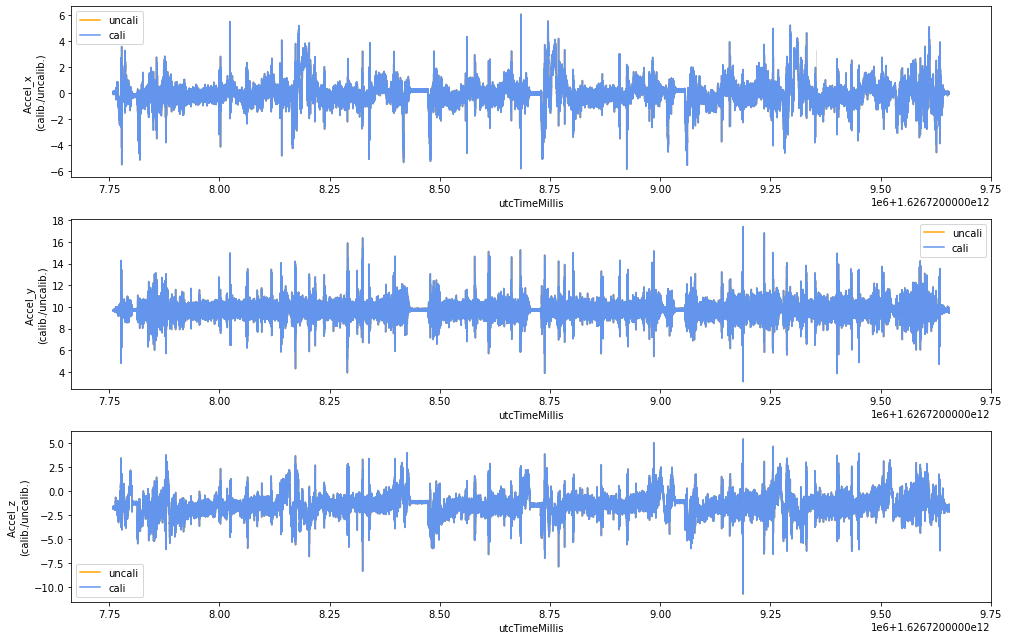

In [175]:
def plot_imu_signals(col, uncali = True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
    ax[0].set_ylabel(f"{col}_x")
    ax[1].set_ylabel(f"{col}_y")
    ax[2].set_ylabel(f"{col}_z")
    if uncali:
        sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"Uncal{col}X"], ax=ax[0], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"Uncal{col}Y"], ax=ax[1], label = 'uncali', color='orange')
        sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"Uncal{col}Z"], ax=ax[2], label = 'uncali', color='orange')
        ax[0].set_ylabel(f"{col}_x \n(calib./uncalib.)")
        ax[1].set_ylabel(f"{col}_y \n(calib./uncalib.)")
        ax[2].set_ylabel(f"{col}_z \n(calib./uncalib.)")
    
    sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"{col}X"], ax=ax[0], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"{col}Y"], ax=ax[1], label='cali', color='cornflowerblue')
    sns.lineplot(x=imu_df.utcTimeMillis, y=imu_df_plot[f"{col}Z"], ax=ax[2], label='cali', color='cornflowerblue')
    
#     start_time = imu_df.utcTimeMillis.median()
#     end_time = imu_df.utcTimeMillis.max()
#     for i in range(3):
#         ax[i].set_xlim([start_time, end_time])
    plt.tight_layout()
    plt.show()
    
plot_imu_signals('Accel')

In [193]:
#The Y axis is representing gravity cuz it sright around 9.8 m/s2
#I think Z represents forward? But why is it so negative
# The X is representing sideways?

#from paper:  The x-axis points to the right of the vehicle, y-axis to the front, and z-axis to the sky
#that doesn't really make sense with the data tho
imu_df_plot['UncalAccelY'].describe()

count    108019.000000
mean          9.723965
std           0.558643
min           3.096911
25%           9.465408
50%           9.725628
75%           9.970892
max          17.425732
Name: UncalAccelY, dtype: float64

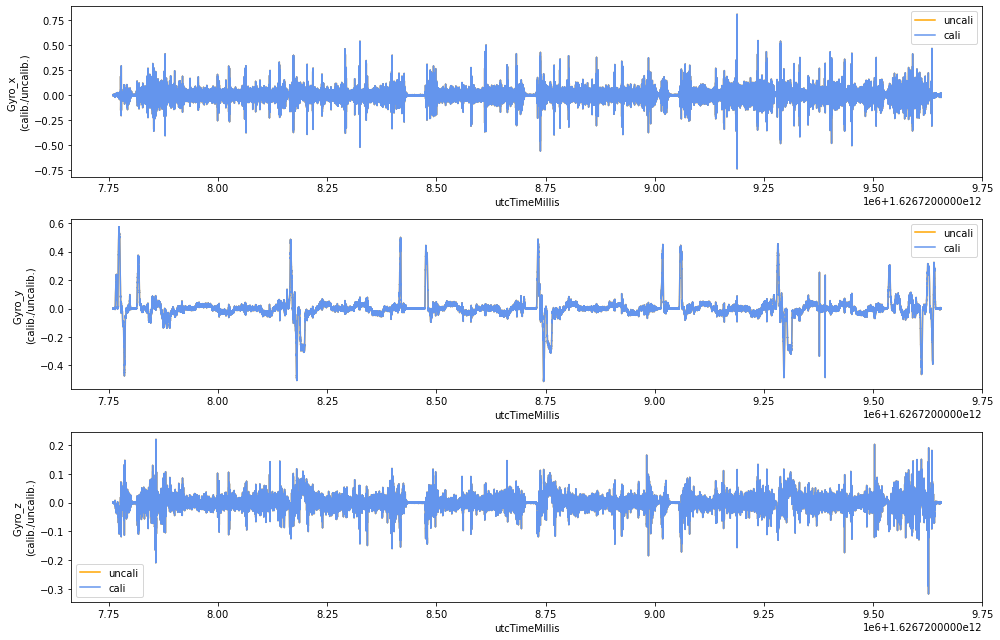

In [176]:
plot_imu_signals('Gyro')

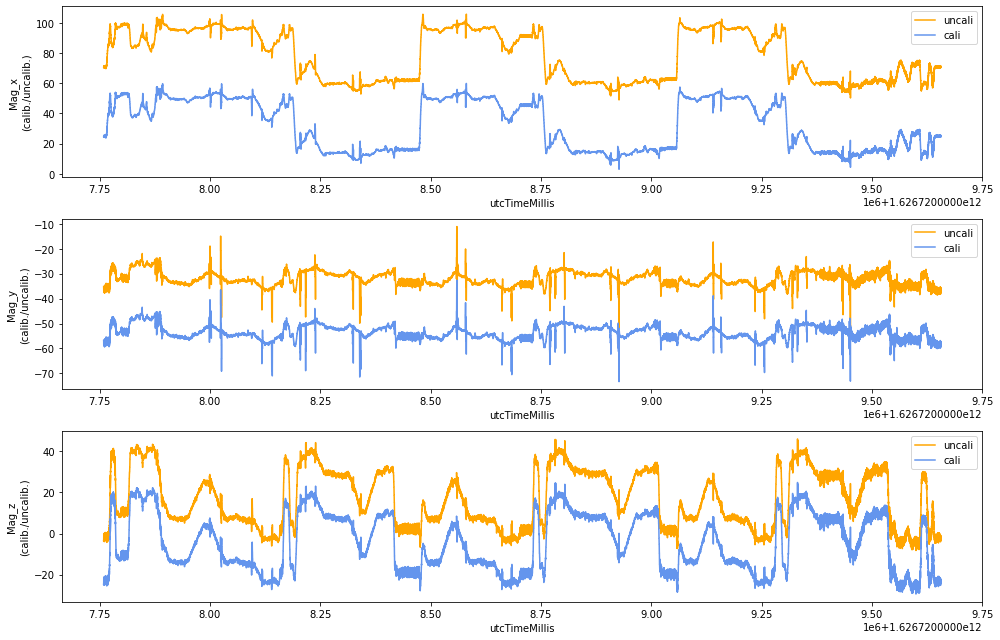

In [177]:
plot_imu_signals('Mag')

In [ ]:
#woah so mag is like super off if i can trust the bias in the data

In [187]:
imu_df_plot.BiasUncalAccelX.max()

#turns out the bias values are all zero for accel and gyro

0.0